In [1]:
# necessary packages
import tensorflow as tf
import pickle

import pandas as pd 
import numpy as np

import os
import sys

import warnings
warnings.filterwarnings('ignore')

from skimage.io import imread
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

import keras
from keras import optimizers
from keras.utils import to_categorical
from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Activation, concatenate
from keras.models import Model
from keras.callbacks import ModelCheckpoint


from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix


In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd '/content/drive/MyDrive/project/'

/content/drive/MyDrive/project


# Data:
 Creating Dataframe for with both text and image data to match final labels with images using img_name as id.

In [4]:
import cv2
import os
import numpy as np

def load_images_from_folder(folder):
    images = []
    image_name = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))

        if img is not None:
            img=cv2.resize(img,(224,224),interpolation=cv2.INTER_AREA)
            images.append(img)
            filename = filename.replace('.jpg', '')
            image_name.append(filename)
    return images, image_name

images_lst, image_names = load_images_from_folder('/content/drive/MyDrive/project/images')

In [5]:
print("shape of the original data",np.array(images_lst).shape)

shape of the original data (3134, 224, 224, 3)


In [6]:
train_data = pd.read_pickle('/content/drive/MyDrive/project/multimodal_text')
train_data

,id,clean_title,2_way_label
0,cozywbv,stargazer,0
1,ctk61yw,yeah,0
2,c0gl7r,pd phoenix car thief gets instructions from yo...,1
3,c0xdqy,as trump accuses iran he has one problem his o...,1
4,7o9rmx,believers hezbollah,0
...,...,...,...
3237,1ugqlf,toronto sunset just before a storm,1
3238,cb1aome,sing it,0
3239,cns9pd3,time to give someone else a turn,0
3240,bws81n,this sleeping snowy owl,1


In [7]:

import pandas as pd

data = pd.DataFrame ({ 'images': images_lst, 'id': image_names}, columns = ['images','id'])

from operator import index

data = pd.merge(data, train_data , on='id')
data

,images,id,clean_title,2_way_label
0,"[[[21, 18, 20], [17, 16, 18], [20, 16, 18], [2...",d27tm6x,sphteven,0
1,"[[[179, 181, 84], [184, 184, 84], [182, 179, 7...",d543enw,shipshape,0
2,"[[[214, 207, 188], [214, 206, 183], [211, 203,...",cj7p949,cutouts,0
3,"[[[80, 94, 111], [84, 95, 109], [64, 73, 84], ...",5t4o7a,embarrassing this punk had of his zippers down,0
4,"[[[255, 141, 147], [255, 142, 148], [255, 141,...",encwky3,its a me mario wahoooo,0
...,...,...,...,...
3129,"[[[156, 178, 203], [149, 171, 196], [149, 171,...",cur52s,the hat i was wearing made my shadow have a pe...,1
3130,"[[[49, 73, 119], [47, 71, 117], [46, 70, 116],...",dag73f,my bell pepper had a tiny bell pepper inside it,1
3131,"[[[30, 16, 10], [30, 16, 10], [31, 16, 10], [3...",cazalq1,other discussions,0
3132,"[[[35, 58, 87], [66, 81, 99], [148, 155, 160],...",7h8rtl,children suffering from anxiety and depression...,1


In [8]:
# Randomly droping few rows from true records

def remove(data,n,m):
    np.random.seed(10)

    df_true = data[data['2_way_label']==0]

    df_fake = data[data['2_way_label']==1]
     
    drop_indices_true = np.random.choice(df_true.index, m, replace=False)
    df_subset_true = df_true.drop(drop_indices_true)
    
    drop_indices_fake = np.random.choice(df_fake.index, n, replace=False)
    df_subset_fake = df_fake.drop(drop_indices_fake)
    
   
    
    df_train_new = pd.concat([df_subset_true, df_subset_fake],ignore_index=True)
    
    return df_train_new

# Randomly droping few rows from true records


data  = remove(data, 1, 300)

# Shuffling a Pandas dataframe with .shuffle()
data = data.sample(frac=1).reset_index()
data

,index,images,id,clean_title,2_way_label
0,2571,"[[[94, 87, 84], [94, 88, 82], [89, 83, 72], [6...",9ibax5,construction workers found another use for har...,1
1,2591,"[[[225, 172, 115], [250, 208, 147], [250, 212,...",7q8c01,this cat hanging out of an suv,1
2,318,"[[[37, 39, 40], [37, 39, 40], [37, 39, 40], [3...",mpuur,cheeky monkey wireless usb,0
3,2327,"[[[10, 66, 47], [23, 63, 49], [37, 57, 50], [3...",ccuptr,this daisys mohawk,1
4,2187,"[[[64, 131, 210], [63, 130, 209], [61, 128, 20...",cv3ky6,a lizard in utah,1
...,...,...,...,...,...
2828,337,"[[[33, 36, 37], [35, 36, 38], [41, 38, 42], [4...",7wtb1p,this little robot quite content with being a g...,0
2829,1715,"[[[129, 51, 92], [99, 36, 67], [93, 33, 60], [...",c6ilov,gog galaxys subtle recruitment ad developer vi...,1
2830,220,"[[[219, 221, 222], [222, 224, 223], [223, 227,...",6fek2o,man thinks his job is secure,0
2831,2803,"[[[45, 57, 67], [52, 63, 73], [57, 67, 77], [5...",2j9ks6,thailand to invite tourists to experience mart...,1


In [9]:
# splitting dataframe by row index
df_test_imgt = data.iloc[:345,:]
df_train_imgt = data.iloc[345:,:]

0    1395
1    1093
Name: 2_way_label, dtype: int64


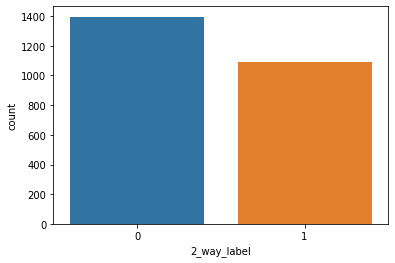

In [10]:
import seaborn as sns 

# Target distribution for training dataset

print(df_train_imgt['2_way_label'].value_counts())

# count plot on single categorical variable
sns.countplot(x ='2_way_label', data = df_train_imgt)

In [11]:
def transformResults(predictions):
    print("""The output here is of the form float, thus we are converting it to binary output based on the following 
condition if a value is > .5 we assign it with 1 and if a value is <.5 we assign it with 0""")
    
    print("\nConverting the ouput to 1D array, and then transformimg the values based on the above condition\n")
    predictions = predictions[:, 0]
    print(f'First 5 values before conversion : {predictions[:5]}')
    
    predictions = [1 if val>0.5 else 0 for val in predictions]
    print(f'First 5 values after the conversion : {predictions[:5]}')
    return predictions

In [12]:
def getResults(y_test, prediction):

    prediction = transformResults(prediction)

    print("\n========== RESULTS ===========\n")
    accuracy = accuracy_score(y_test, prediction)
    precision = precision_score(y_test, prediction)
    f1 = f1_score(y_test, prediction)
    recall = recall_score(y_test, prediction)

    print(f'Accuracy : {accuracy}\nPrecision : {precision}\nF1_score : {f1}\nRecall : {recall}\n')
    
    print("===== CONFUSION MATRIX =====")
    cf_matrix = confusion_matrix(y_test, prediction)
    print(cf_matrix)
    
    return accuracy, precision, f1, recall

# Image Classification

VGG16 is a convolutional neural network model proposed in the paper "Very Deep Convolutional Networks for Large-Scale Image Recognition" by K. Simonyan and A. Zisserman of the University of Oxford. This architecture has layers such as Convolutional2D +ReLU, max pooling, Fully netted + ReLU. 

Featuresmap of the train and test data is extracted using .predict()  from pre-trained weights of VGG16.This allows to extract as meaning data as possible from data features(images). 

include_top = False allows us to get features before dense layers, so output shape is 7x7x512. We use these features to train on our dataset by adding 2 Dense layers and softmax activation.



In [13]:
df_train= df_train_imgt[['images','2_way_label']]
df_test = df_test_imgt[['images','2_way_label']]
df_train

,images,2_way_label
345,"[[[150, 127, 116], [172, 155, 147], [172, 152,...",0
346,"[[[3, 22, 5], [7, 38, 18], [14, 64, 40], [8, 7...",1
347,"[[[30, 30, 30], [26, 26, 26], [20, 20, 20], [2...",0
348,"[[[154, 124, 98], [155, 124, 99], [157, 125, 1...",0
349,"[[[165, 125, 117], [151, 110, 98], [90, 82, 86...",0
...,...,...
2828,"[[[33, 36, 37], [35, 36, 38], [41, 38, 42], [4...",0
2829,"[[[129, 51, 92], [99, 36, 67], [93, 33, 60], [...",1
2830,"[[[219, 221, 222], [222, 224, 223], [223, 227,...",0
2831,"[[[45, 57, 67], [52, 63, 73], [57, 67, 77], [5...",1


In [14]:
from sklearn.utils import shuffle

    
def datapartition(dataset,col):
    #Split data into a test and training set
    X = np.array(dataset[col].tolist())
    y = np.array(dataset['2_way_label'])
    
    if col == 'images':
      #scaling the features
      X = X/255.0

    return X,y
    
    

# split the data after normalizing and reshaping using helper function

X_train_img, y_train_img= datapartition(df_train,'images')
print("Train data size: ", X_train_img.shape, y_train_img.shape)

X_test_img, y_test_img= datapartition(df_test,'images')
print("test data size: ", X_test_img.shape, y_test_img.shape)

Train data size:  (2488, 224, 224, 3) (2488,)
test data size:  (345, 224, 224, 3) (345,)


In [16]:
import random
from keras.applications import vgg16

# Pretrained convolutional layers are loaded using the Imagenet weights.
# Include_top is set to False, in order to exclude the model's fully-connected layers.


conv_base = vgg16.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224,224,3)
                 )

conv_base.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [17]:
# Extract training feature map from vgg16 conv_base
train_featuremap = conv_base.predict(X_train_img)
test_featuremap = conv_base.predict(X_test_img) 

11/11 [==============================] - 178s 16s/step


In [18]:
train_features = np.array(train_featuremap)
train_features = train_features.reshape((-1,7,7,512))

test_features = np.array(test_featuremap)
test_features = test_features.reshape((-1,7,7,512))

'''
reshape_y = 7 * 7 * 512

nb_train_samples = train_featuremap.shape[0]
nb_test_samples = test_featuremap.shape[0] 

# Shape data
reshape_y = 7 * 7 * 512

train_features = np.reshape(train_featuremap, (nb_train_samples, reshape_y))
test_features = np.reshape(test_featuremap, (nb_test_samples, reshape_y))
'''

'\nreshape_y = 7 * 7 * 512\n\nnb_train_samples = train_featuremap.shape[0]\nnb_test_samples = test_featuremap.shape[0] \n\n# Shape data\nreshape_y = 7 * 7 * 512\n\ntrain_features = np.reshape(train_featuremap, (nb_train_samples, reshape_y))\ntest_features = np.reshape(test_featuremap, (nb_test_samples, reshape_y))\n'

In [24]:
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, LeakyReLU

def create_model(input_img, input_shape):

  # Build classifier on top of  VGG16
  x = Flatten()(input_img)
  x = Dense(64, activation='relu')(x)
  x = Dense(128, activation='relu')(x)

  return x




In [25]:
# create image input
from keras.layers import Input

input_shape = (7,7,512)

input_img = Input(shape=(7,7,512), name="vgg_input")

image_output = create_model(input_img, input_shape)
image_output

<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'dense_4')>

In [27]:
#evaluating model on image data

image_output = Dense(16)(image_output)
output = Dense(1, name='output_layer', activation='sigmoid')(image_output)

# To define the model, pass list of input layers
model_cnn_img = Model(inputs=input_img, outputs=output)

model_cnn_img.compile(optimizer=optimizers.RMSprop(lr=5e-6),
              loss='binary_crossentropy',
              metrics=['acc'])

# To fit the model, pass a list of inputs arrays
model_cnn_img.fit(x=train_features,y=y_train_img,epochs=15,
                    batch_size=16,
                    validation_split=0.2)

Epoch 1/15
125/125 [==============================] - 4s 23ms/step - loss: 0.6872 - acc: 0.5653 - val_loss: 0.6847 - val_acc: 0.5361
Epoch 2/15
125/125 [==============================] - 3s 21ms/step - loss: 0.6520 - acc: 0.6372 - val_loss: 0.6769 - val_acc: 0.5522
Epoch 3/15
125/125 [==============================] - 3s 22ms/step - loss: 0.6320 - acc: 0.6593 - val_loss: 0.6725 - val_acc: 0.5703
Epoch 4/15
125/125 [==============================] - 3s 21ms/step - loss: 0.6152 - acc: 0.6834 - val_loss: 0.6710 - val_acc: 0.5622
Epoch 5/15
125/125 [==============================] - 3s 21ms/step - loss: 0.5996 - acc: 0.6940 - val_loss: 0.6672 - val_acc: 0.5924
Epoch 6/15
125/125 [==============================] - 3s 21ms/step - loss: 0.5845 - acc: 0.7161 - val_loss: 0.6655 - val_acc: 0.5944
Epoch 7/15
125/125 [==============================] - 3s 21ms/step - loss: 0.5702 - acc: 0.7211 - val_loss: 0.6640 - val_acc: 0.5884
Epoch 8/15
125/125 [==============================] - 3s 21ms/step - 

In [28]:

#predictions on test data
predictions = model_cnn_img.predict(test_features)
print(predictions[:,0])

CNN_image_results = getResults(y_test_img, predictions)

11/11 [==============================] - 0s 7ms/step
[0.2910454  0.5318058  0.50506514 0.2876656  0.64608485 0.31891373
 0.51340485 0.2654705  0.59422076 0.15994652 0.16672252 0.41179967
 0.3940989  0.16507174 0.2010499  0.15539625 0.5349463  0.28159624
 0.33169165 0.3603062  0.41613576 0.52621    0.23011777 0.21692128
 0.35355458 0.25298268 0.4091612  0.4229292  0.46245095 0.50050896
 0.22627324 0.19148842 0.21022761 0.2962627  0.31727985 0.506745
 0.44677898 0.41797978 0.40777937 0.12007196 0.56344676 0.7083251
 0.28801587 0.23180288 0.27710286 0.58617896 0.5871116  0.55615246
 0.21444723 0.58727413 0.16266015 0.51767784 0.2628607  0.39948654
 0.57932115 0.5010565  0.5024949  0.4519496  0.49758956 0.4086807
 0.6052166  0.37148312 0.38980532 0.5752522  0.41461658 0.27982008
 0.4824449  0.33415717 0.14345144 0.64485025 0.36075252 0.06020639
 0.31794035 0.04287592 0.50726026 0.2589376  0.18804358 0.46090594
 0.50865674 0.24741359 0.30369025 0.41207126 0.3932177  0.35078576
 0.2736681  0

Method to test the Accuracy, Precision, Recall and F1 Score The following method transforms the output to binary values before calculating the scores

# Text classification

The most basic concept is to train textual input directly. The length of each clean title, on the other hand, may vary. As a result, using recurrent layers rather than only dense layers is preferable.Furthermore, we cannot feed words into neural networks. But, most wide-spread solution is to map each word with a number using text preprocessors.

There is an Embedding layer in Keras that associates a vector with each input given vocabulary length. Then we add one LSTM and three Dense layers.

In [29]:
df_train= df_train_imgt[['clean_title','2_way_label']]
df_test = df_test_imgt[['clean_title','2_way_label']]
df_train

,clean_title,2_way_label
345,how to annoy four groups of fans with one image,0
346,this super happy cat,1
347,film poster for kolberg the last big nazi film...,0
348,cutouts,0
349,she took the lead,0
...,...,...
2828,this little robot quite content with being a g...,0
2829,gog galaxys subtle recruitment ad developer vi...,1
2830,man thinks his job is secure,0
2831,thailand to invite tourists to experience mart...,1


In [45]:
from sklearn.utils import shuffle

def xy_data(data):

  data = shuffle(data)

  data.reset_index(inplace=True, drop=True)

  x_features = data['clean_title']
  
  y = data['2_way_label']
  
  display(x_features.head())
  display(y.head())

  return x_features, y

X_train_t, y_train_t = xy_data(df_train)
 
X_test_t, y_test_t = xy_data(df_test)

0          aw is paying to put mini ads in mens beards
1             per fetish request in comments camel toe
2    lets celebrate uprising day yugoslavcroatian p...
3                         my cornetto had two wrappers
4                                            interview
Name: clean_title, dtype: object

0    1
1    0
2    0
3    1
4    0
Name: 2_way_label, dtype: int64

0                         i cant unsee the creepy face
1           youll never guess who owns go tribe phrase
2               christopher columbus discovers america
3                               to meow or not to meow
4    this music stand from a school my dad used to ...
Name: clean_title, dtype: object

0    0
1    0
2    0
3    0
4    1
Name: 2_way_label, dtype: int64

In [46]:
from keras.preprocessing.text import Tokenizer

from keras_preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_t)

X_train_t = tokenizer.texts_to_sequences(X_train_t)
X_test_t = tokenizer.texts_to_sequences(X_test_t)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 300

X_train_t = pad_sequences(X_train_t, padding='post', maxlen=maxlen)
X_test_t= pad_sequences(X_test_t, padding='post', maxlen=maxlen)

In [47]:
cd '/content/drive/MyDrive/project/'

/content/drive/MyDrive/project


In [48]:

embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [63]:
from keras.layers import Flatten, GlobalMaxPooling1D, Conv1D
from keras.layers import Embedding
from keras.layers import Bidirectional

def getBidirectionalModel(text_input):
    # Input for variable-length sequences of integers
    # Embedding layer
    x = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(text_input)
    x = Conv1D(128, 5, activation='relu')(x)
    # Add maxpooling layers
    x = Dense(64, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)
    x = Flatten()(x)

    return x
# create image input
from keras.layers import Input

text_input = Input(shape=(maxlen,))

text_output = getBidirectionalModel(text_input)

In [64]:
from keras.layers import Dense

dense = Dense(16, activation='relu')(text_output)
output = Dense(1, name='output_layer', activation='sigmoid')(dense)

# To define the model, pass list of input layers
model_cnn_text = Model(inputs=text_input, outputs=output)
model_cnn_text.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

# To fit the model, pass a list of inputs arrays
model_cnn_text.fit(x=X_train_t,y=y_train_t,epochs=5,
                    batch_size=16,
                    validation_split=0.2)

Epoch 1/5
125/125 [==============================] - 8s 55ms/step - loss: 0.5763 - acc: 0.7090 - val_loss: 0.5126 - val_acc: 0.7691
Epoch 2/5
125/125 [==============================] - 7s 53ms/step - loss: 0.3987 - acc: 0.8402 - val_loss: 0.6490 - val_acc: 0.6807
Epoch 3/5
125/125 [==============================] - 7s 53ms/step - loss: 0.2695 - acc: 0.9060 - val_loss: 0.4936 - val_acc: 0.7771
Epoch 4/5
125/125 [==============================] - 7s 52ms/step - loss: 0.1482 - acc: 0.9608 - val_loss: 0.5253 - val_acc: 0.7771
Epoch 5/5
125/125 [==============================] - 7s 53ms/step - loss: 0.0711 - acc: 0.9864 - val_loss: 0.5623 - val_acc: 0.7811


In [65]:
#predictions on test data
predictions = model_cnn_text.predict(X_test_t)

CNN_text_results = getResults(y_test_t, predictions)

11/11 [==============================] - 1s 39ms/step
The output here is of the form float, thus we are converting it to binary output based on the following 
condition if a value is > .5 we assign it with 1 and if a value is <.5 we assign it with 0

Converting the ouput to 1D array, and then transformimg the values based on the above condition

First 5 values before conversion : [0.03989056 0.00312041 0.25872022 0.00945204 0.9644907 ]
First 5 values after the conversion : [0, 0, 0, 0, 1]

========== RESULTS ===========

Accuracy : 0.7391304347826086
Precision : 0.7416666666666667
F1_score : 0.664179104477612
Recall : 0.6013513513513513

===== CONFUSION MATRIX =====
[[166  31]
 [ 59  89]]



# Multimodal Classification

Finally, the results of VGG16 show that images alone are insufficient for news classification. This is due to the image content. When we look at images, we notice that there aren't enough features to identify the respective category.

Pre-trained embeddings and CNN models perform better than our base learner approaches. As a result, CNN + VGG16 and GLoVe+BI-LSTM multimodal architectures were trained.

In [72]:
from keras.layers import Dense, Concatenate

# Concatenate the features
concatenate_layer = Concatenate(name='concatenation')([text_output, image_output]) 

dense = Dense(16)(concatenate_layer)
output = Dense(1, name='output_layer', activation='sigmoid')(dense)

# To define the model, pass list of input layers
model_cnn = Model(inputs=[ text_input, input_img], outputs=output)
model_cnn.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['acc'])

# To fit the model, pass a list of inputs arrays
history = model_cnn.fit(x=[ X_train_t, train_features], y=y_train_t,epochs=5,
                    batch_size=16,
                    validation_split=0.3)

Epoch 1/5
109/109 [==============================] - 9s 70ms/step - loss: 0.2917 - acc: 0.8909 - val_loss: 0.4274 - val_acc: 0.8447
Epoch 2/5
109/109 [==============================] - 9s 86ms/step - loss: 0.0290 - acc: 1.0000 - val_loss: 0.4919 - val_acc: 0.8394
Epoch 3/5
109/109 [==============================] - 7s 66ms/step - loss: 0.0093 - acc: 1.0000 - val_loss: 0.5486 - val_acc: 0.8380
Epoch 4/5
109/109 [==============================] - 7s 67ms/step - loss: 0.0047 - acc: 1.0000 - val_loss: 0.5999 - val_acc: 0.8327
Epoch 5/5
109/109 [==============================] - 9s 86ms/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.6327 - val_acc: 0.8327


In [71]:
#predictions on test data
predictions = model_cnn.predict([ X_test_t, test_features])

CNN_multimodal_results = getResults(y_test_t, predictions)

11/11 [==============================] - 1s 36ms/step
The output here is of the form float, thus we are converting it to binary output based on the following 
condition if a value is > .5 we assign it with 1 and if a value is <.5 we assign it with 0

Converting the ouput to 1D array, and then transformimg the values based on the above condition

First 5 values before conversion : [1.1926038e-03 2.9455751e-04 9.2804901e-02 1.8150012e-04 9.5913249e-01]
First 5 values after the conversion : [0, 0, 0, 0, 1]

========== RESULTS ===========

Accuracy : 0.7536231884057971
Precision : 0.7787610619469026
F1_score : 0.6743295019157088
Recall : 0.5945945945945946

===== CONFUSION MATRIX =====
[[172  25]
 [ 60  88]]


In [73]:
# create dataframe with results from above models

columns = ['Modality','Accuracy','Precision','F1-score','Recall']

df_results = pd.DataFrame(columns =columns)

def results_data(scores, df, modality):

  # generating data to tabulate results
  scores =list(scores) 
  scores.insert(0,modality)

  #append the score to dataframe
  df = df.append(pd.DataFrame(np.array(scores).reshape(1,-1), columns=list(df)), ignore_index=True)

  return df


df_results = results_data(CNN_image_results, df_results, 'visual modality' )

df_results = results_data(CNN_text_results, df_results, 'textual modality' )

df_results = results_data(CNN_multimodal_results, df_results, 'visual + textual modality' )


**Discussion**

Although we obtained good results, the performance is 90% because of the inconsistent data source. Furthermore, due to a lack of computational resources, more advanced models such as ResNet could not be used for image processing. However, it is clear that image features degrade the performance of the better performing text models.

But it is clearly seen that the multimodal classification is performing far better than image or text classification models.

In [74]:
df_results

,Modality,Accuracy,Precision,F1-score,Recall
0,visual modality,0.6260869565217392,0.5922330097087378,0.4860557768924303,0.41216216216216217
1,textual modality,0.7391304347826086,0.7416666666666667,0.664179104477612,0.6013513513513513
2,visual + textual modality,0.7536231884057971,0.7787610619469026,0.6743295019157088,0.5945945945945946
